In [15]:
from funcoes.funcoes import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [16]:
LC_defaults = pd.read_csv('dados/dados_WoE_VI_LGD_EAD_regressao.csv')

In [17]:
# importando modelos

modelo_lgd1 = joblib.load('modelos/modelo_lgd_v1.sav')
modelo_lgd2 = joblib.load('modelos/modelo_lgd_v2.sav')
modelo_ead  = joblib.load('modelos/modelo_ead_v1.sav')
modelo_pd   = joblib.load('modelos/modelo_pi.sav')

# Cálculo da Perda Esperada
---


#### LGD

In [19]:
# separando dados

X = LC_defaults.drop(['target', 'taxa_recuperacao', 'taxa_recuperacao_0_1', 'fator_conversao_credito', 'funded_amnt', 'total_rec_prncp', 'recoveries'], axis = 1)

In [20]:
# combinando os valores previstos do modelo parte 1 (regressão logística) 
# e do modelo parte 2 (regressão linear)
# para calcular a taxa de recuperação final estimada

LC_defaults['taxa_recuperacao_1'] = modelo_lgd1.model.predict(X)
LC_defaults['taxa_recuperacao_2'] = modelo_lgd2.predict(X)

LC_defaults['taxa_recuperacao_final'] = LC_defaults['taxa_recuperacao_1'] * LC_defaults['taxa_recuperacao_2']

In [21]:
LC_defaults['taxa_recuperacao_final'] = np.where(LC_defaults['taxa_recuperacao_final'] < 0, 0, LC_defaults['taxa_recuperacao_final'])
LC_defaults['taxa_recuperacao_final'] = np.where(LC_defaults['taxa_recuperacao_final'] > 1, 1, LC_defaults['taxa_recuperacao_final'])

In [22]:
# calcula-se a LGD estimada
# a LGD estimada é igual a 1 - taxa de recuperação estimada

LC_defaults['LGD'] = 1 - LC_defaults['taxa_recuperacao_final']

LC_defaults['LGD'].describe()

count    466285.000000
mean          0.999999
std           0.000233
min           0.897555
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

#### EAD

In [25]:
X2 = LC_defaults.drop(['target', 'taxa_recuperacao','taxa_recuperacao_0_1','fator_conversao_credito', 'LGD', 'taxa_recuperacao_final', 'taxa_recuperacao_1', 'taxa_recuperacao_2'], axis = 1)

In [26]:
# aplica-se o modelo EAD para calcular o fator de conversão de crédito estimado

LC_defaults['CCF'] = modelo_ead.predict(X2)

LC_defaults['CCF'] = np.where(LC_defaults['CCF'] < 0, 0, LC_defaults['CCF'])
LC_defaults['CCF'] = np.where(LC_defaults['CCF'] > 1, 1, LC_defaults['CCF'])

In [27]:
# calcula-se o EAD estimado
# EAD estimado é igual ao CCF estimado multiplicado pelo valor financiado

LC_defaults['EAD'] = LC_defaults['CCF'] * LC_defaults['funded_amnt']

LC_defaults['EAD'].describe()

count    466285.000000
mean        921.227667
std        4106.488453
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       35000.000000
Name: EAD, dtype: float64

#### PD

In [29]:
LC_defaults_pd = pd.read_csv('dados/selected_data.zip')

In [33]:
# aplica-se o modelo PD para calcular as probabilidades de default estimadas

modelo_pd.model.predict_proba(LC_defaults_pd.drop(['target'], axis = 1))[: ][: , 0]

array([0.15581761, 0.25684906, 0.21954045, ..., 0.20062101, 0.02554551,
       0.16189827])

In [36]:
LC_defaults_pd['PD'] = modelo_pd.model.predict_proba(LC_defaults_pd.drop(['target'], axis = 1))[:][: , 0]

In [37]:
LC_defaults_pd['PD'].head()

0    0.155818
1    0.256849
2    0.219540
3    0.209475
4    0.134201
Name: PD, dtype: float64

In [38]:
LC_defaults_pd['PD'].describe()

count    466285.000000
mean          0.109339
std           0.071227
min           0.007104
25%           0.055749
50%           0.093480
75%           0.147036
max           0.657238
Name: PD, dtype: float64

### Perda Esperada

In [39]:
# junta-se os dataframes onde calculamos LGD e EAD e o 
# dataframe onde calculamos PD ao longo das colunas

LC_defaults_new = pd.concat([LC_defaults, LC_defaults_pd], axis = 1)

In [40]:
LC_defaults_new.shape

(466285, 223)

In [41]:
LC_defaults_new.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,addr_state:NY,...,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,target,PD
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.155818
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.256849
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.219540
3,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.209475
4,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0.134201


In [42]:
# calculando a Perda Esperada
# EL = PD * LGD * EAD

LC_defaults_new['EL'] = LC_defaults_new['PD'] * LC_defaults_new['LGD'] * LC_defaults_new['EAD']

In [43]:
LC_defaults_new['EL'].describe()

count    466285.000000
mean        152.173132
std         769.262386
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       16148.558834
Name: EL, dtype: float64

In [44]:
LC_defaults_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,PD,LGD,EAD,EL
0,0.0,0.155818,1.0,0.000000,0.000000
1,2500.0,0.256849,1.0,465.478132,119.557622
2,0.0,0.219540,1.0,0.000000,0.000000
3,0.0,0.209475,1.0,0.000000,0.000000
4,0.0,0.134201,1.0,0.000000,0.000000


In [45]:
LC_defaults_new['funded_amnt'].describe()

count    466285.000000
mean       1333.221796
std        4882.769721
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       35000.000000
Name: funded_amnt, dtype: float64

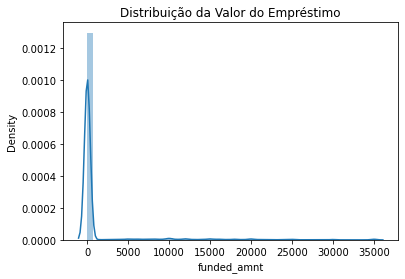

In [46]:
plt.title('Distribuição da Valor do Empréstimo')
sns.distplot(LC_defaults_new.funded_amnt);

In [47]:
# Perda Total Esperada para todos os empréstimos

LC_defaults_new['EL'].sum()

70956048.72462437

In [48]:
# valor total financiado para todos os empréstimos

LC_defaults_new['funded_amnt'].sum()

621661325.0

In [49]:
# perda total esperada como proporção do valor total financiado para todos os empréstimos

LC_defaults_new['EL'].sum() / LC_defaults_new['funded_amnt'].sum()

0.11413939692102346

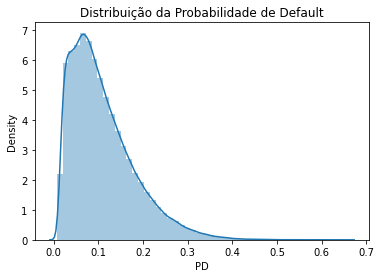

In [50]:
plt.title('Distribuição da Probabilidade de Default')
sns.distplot(LC_defaults_new.PD);

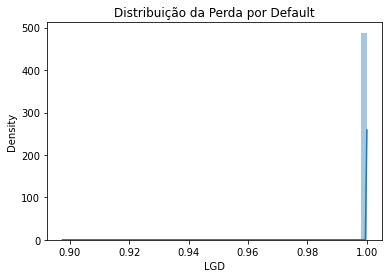

In [51]:
plt.title('Distribuição da Perda por Default')
sns.distplot(LC_defaults_new.LGD);

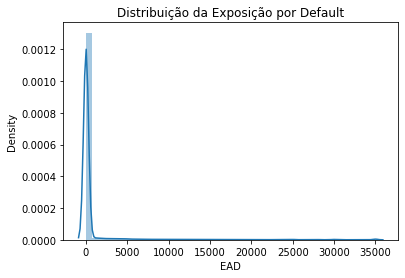

In [52]:
plt.title('Distribuição da Exposição por Default')
sns.distplot(LC_defaults_new.EAD);

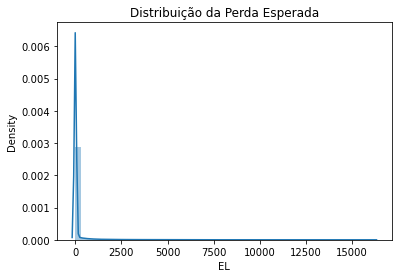

In [53]:
plt.title('Distribuição da Perda Esperada')
sns.distplot(LC_defaults_new.EL);

(CORRIGIR) Nesta etapa os modelos anteriores foram aplicados no conjunto de dados e, de acordo com os resultados, a perda esperada do dataset selecionado possui média de U\\$ 592.28, desvio padrão de U\\$ 1.639.46, e valor máximo de U\\$ 37.975,99. A soma total da perda esperada do portifólio é de U\\$ 519.819.141,88 e, por fim, proporcão da perda esperada pelo valor dos empréstimo é 3.8%.

---